In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits, ascii
%matplotlib inline
import glob
import emcee
from math import log
import corner

/Users/ih64/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


## Problem 1 MCMC practice

The code used to do the third degree polynomial fit is heavily borrowed from CDF's python tutorial on emcee, which shows how to use emcee to do a striaght line fit. Any changes are expalined with comments

<Container object of 3 artists>

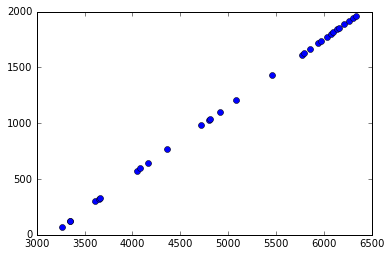

In [33]:
#read in our data and unpackage it. 
#we will assume .4pixel errors on every data point
table=ascii.read('wavecal.txt')
x = table['wavelength'].data
y = table['x_postion'].data
yerr=np.ones(len(x))*.4

#lets plot it to make sure a polynomial fit is reasonable enough
plt.errorbar(x,y,yerr, fmt='bo')

A polynomial fit should be fine. Lets use emcee to do it

### 1a) use emcee to find the parameters and make a corner plot

In [2]:
"""
Set up the likelihood function.  Inputs are the parameter vector, and then x, y, and yerr. 
"""

def lnlikelihood(pars, x, y, yerr):
    """ 
    Takes the current values of the parameters (pars), plus the data (x, y, yerr) and returns
    ln(likelihood) for the current parameter values
    we are using a 3rd degree polynomial for our model
    """
    y_model = pars[0] + pars[1]*x + pars[2]*(x**2) + pars[3]*(x**3)
    lnl = -(y -y_model)**2/yerr**2
    return lnl.sum()

In [3]:
'''
Set up log priors for our parameters
'''
def lnprior(pars):
    #we have some intuition for the first three parameters from previous work
    a0_init=-2.07890788e+03
    a1_init=6.85415206e-01
    a2_init=-7.70324311e-06
    
    #based on previous fitting, we saw the the higher order terms tend to change more when the
    #order of the model is increased. Bearing this in mind, we choose flat priors on our first three parameters
    #which are centered around the results of the Maximum Liklihood analysis for polyonmial fitting. 
    
    #because we expect the higher order parameters to change more, we increase the 'width' of these
    #distributions logorithmicly 
    
    a0_cond=a0_init + a0_init < pars[0] < a0_init - a0_init
    a1_cond=a1_init - a1_init*10 < pars[1] < a1_init + a1_init*10
    a2_cond=a2_init + a2_init*100 < pars[2] < a2_init - a2_init*100
    
    #we have no information about the last parameter. However, we saw in previous work
    #that the highest power tends to serve as a small correction to the lower power form of the model
    #so we expect the parameter to be << |1|. A uniform region centered around 0, going from -3 to 3 should
    #give more than enough parameter space to explore
    if a0_cond and a1_cond and a2_cond and -3. < pars[3] < 3. :
        return 0.0 # Since log(1) = 0
    else:
        return -np.inf

In [4]:
"""
Set up the unnormalized posterior probability function that is the product of the
likelihood and the priors.
"""

def lnprob(pars, x, y, yerr):
    lp = lnprior(pars)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlikelihood(pars, x, y, yerr)

In [23]:
nwalkers=200

#a third degree polynomial fit has 4 dimensions
ndim=4

#intialize the first three parameters to the values obtained from 
#Maximum Liklihood Analysis of a 2nd degree polynomial fit
a0_init=-2.07890788e+03
a1_init=6.85415206e-01
a2_init=-7.70324311e-06

#for each Parameter, we want to initialize our walkers away from eachother. So we introduce a small 
#step away from initial guess for every walker, for every parameter. 
#we have Maximum Liklihood work to guide our initial spots for the first three parameters.
#the size of the step is scaled down ~1 order of magnitude from the initial location's value
#this will ensure our walkers are spread out a bit, but not so far that some of them fall outsie of the 
#liklihood regions described in lnprior()
a0_0= a0_init + 100*(2*np.random.random_sample(nwalkers) - 1)
a1_0= a1_init + 1e-2 * (2*np.random.random_sample(nwalkers) - 1)
a2_0= a2_init + 1e-7 * (2*np.random.random_sample(nwalkers) - 1)

#the last parameter has a flat prior between -3 and 3 and we have no information about its value.
#there fore we choose initial guesses of 0 for the walkers and add on a step away anywhere between -1 and 1
a3_0=2*np.random.random_sample(nwalkers) - 1

#group our walkers together
p0=np.array([a0_0,a1_0,a2_0,a3_0]).T

#set up the mcmc sampler
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(x, y, yerr))

""" 
Take the initial guesses and then do a 'burn-in' to get the walkers to a better
location in parameter space
"""
nburn = 500
pos, prob, state = sampler.run_mcmc(p0, nburn)

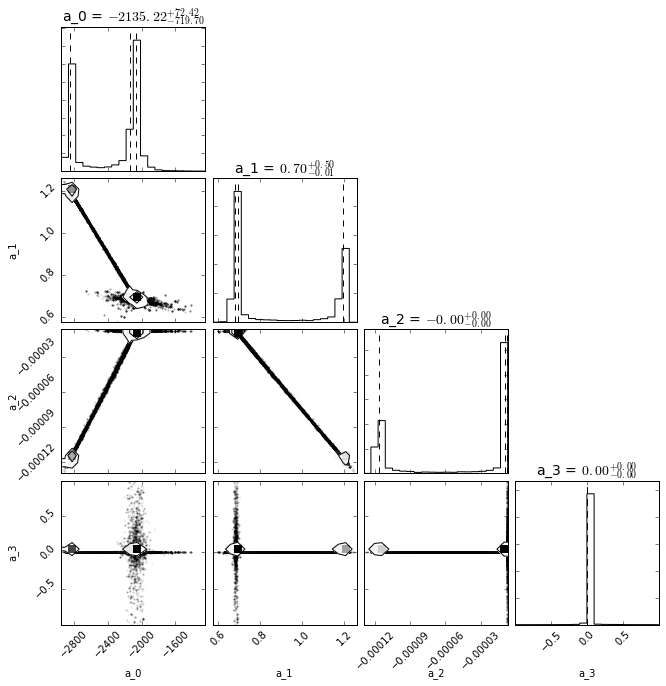

In [24]:
#lets have a look at what our walkers found in the burn in steps
samples = sampler.chain.reshape((-1,ndim))
plt.figure(figsize=(9,9))
fig = corner.corner(samples,labels=['a_0','a_1','a_2','a_3'],quantiles=[0.16, 0.5, 0.84],
                    show_titles=True,title_kwargs={"fontsize": 14})

It looks like our choice for the number of burnins was reasonable enough. Based on the PDFs and cross correlations, it looks like the walkers did some wandering about the initial guesses, then migrated over to an area of high significance. Now we can use the results of the burn in run to initialize an MCMC with improved initial positions, and really beat up on the PDFs

In [25]:
"""
Now run the MCMC for real.
"""
sampler.reset()
niter = 5000
mcmc = sampler.run_mcmc(pos, niter, rstate0=state)

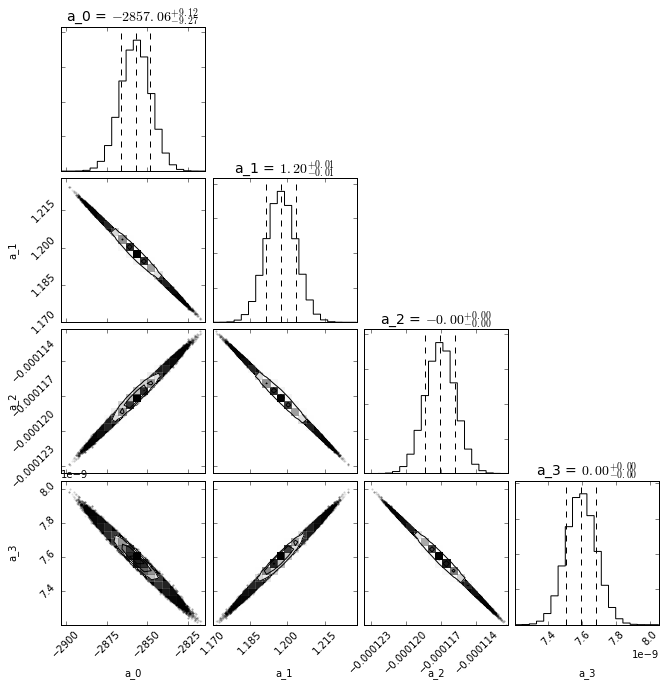

In [26]:
#lets look at what the walkers found in our post-burn-in MCMC
samples = sampler.chain.reshape((-1,ndim))
plt.figure(figsize=(9,9))
fig = corner.corner(samples,labels=['a_0','a_1','a_2','a_3'],quantiles=[0.16, 0.5, 0.84],
                    show_titles=True,title_kwargs={"fontsize": 14})

There are now high significance peaks in all the PDFs for the parameters in our model, and none of the bimodal features from the burn in corner-plots that were biased towards the initial guesses for the parameters from Maximum Liklihood Estimation. Ther parameters are highly correlated, as well. The values of the higher order terms, and their uncertainties, are not printed-there isnt enough room on the plot for the significant digets required. Lets calculate them now.

### 1b) report the parameter values and their 68% confidence regions

In [31]:
'''
make a function to recieve the sampler, and desired parameter. 
gathers all the chains for the desired sampler and computes median, and 68% confidence interval
based in very large part off of the MCMC tutorial CDF provided
'''

def printCI(sampler,n):
    ans = sampler.flatchain[:,n]
    """ Estimate the 68% range, as well as the median point """
    ans.sort()
    anm = ans[int(0.16 * ans.size)]
    anp = ans[int(0.84 * ans.size)]
    anmed = ans[int(0.5 * ans.size)]
    print 'a%i = %.4e.' % (n,anmed)
    print '  68 percent CL: %.4e - %.4e' % (anm,anp)
    print ''
    return

In [32]:
for i in xrange(0,ndim):
    printCI(sampler,i)

a0 = -2.8571e+03.
  68 percent CL: -2.8663e+03 - -2.8479e+03

a1 = 1.1975e+00.
  68 percent CL: 1.1915e+00 - 1.2035e+00

a2 = -1.1706e-04.
  68 percent CL: -1.1834e-04 - -1.1579e-04

a3 = 7.5922e-09.
  68 percent CL: 7.5047e-09 - 7.6814e-09



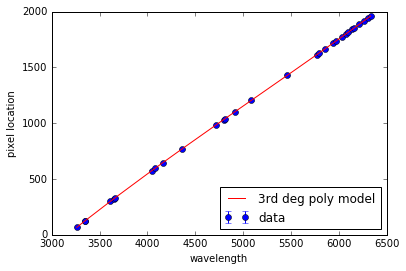

In [39]:
#finally we plot the model with the data to make sure it passes the sanity test
ymodel = -2.8571e+03 + 1.1975e+00 * x + -1.1706e-04 * (x**2) + 7.5922e-09* (x**3)

plt.errorbar(x,y,yerr, fmt='bo', label='data')
plt.plot(x,ymodel,'r', label='3rd deg poly model')
plt.legend(loc="lower right")
plt.xlabel('wavelength')
plt.ylabel('pixel location')

## Problem 2: A first data reduction pipeline

first lets remember the code we wrote up to do sigma clipping

In [14]:
def sigmaClip(data, nsigma, call=1):
    '''sigma clipping algorithm. recieves a numpy array, identifies mean, std, discards elements
    above or below nsigma*std the mean, repeat until no more elements are outside threshold.
    
    python is notoriously slow with loops. instead we implement a recursive algorithm.
    if elements have been discarded, the function will call itself and continue to do so
    until there are no more elements outside of threshold
    
    inputs:
        data: a 1d numpy array
        nsigma: the number of sigma away from the mean you want to clip off
        call: counts the number of recursive call the function makes. 
    outputs: 
        data: the surviving elements from input data
    '''
    
    #calculate the mean, std, and threshold
    mean=data.mean()
    std=data.std()
    threshold=nsigma*std
    
    #define the upper limit
    up_thresh=mean+threshold
    #define lower limit
    down_thresh=mean-threshold
    
    #create the mask to identify elements between thresholds
    good_mask= ((data <= up_thresh) & (data >= down_thresh))

    #define the testcase. if this is true the program will exit
    #if there are no elements above or below threshold, we're done.
    #print out the mean and std, then return the clipped array.
    #finally, return the masked array 
    if data[~good_mask].size == 0:
        print "after %i recursive calls, we have no more elements outside threshold" %(call)
        print "the mean and std of the final clipped array are %.5f and %.5f respectively" %(data.mean(), data.std())
        return
    
    #if that's not the case, recurse on the subproblem. 
    #keep using the same nsigma the user defined in the very first call
    #incrament the call by one so we can keep track of how many recursive calls the function makes
    #then the function will call itself on the clipped version of the data array it recieved
    else:
        call+=1
        return sigmaClip(data[good_mask], nsigma,call=call)

Now we will calculate the median dark frame, and use the sigma clipping algorithm to determine the settings to use when displaying it

### 2a) Dark Subtraction

In [15]:
def dark_median(darks):
    '''
    calculate the median flat field image
    
    input:
        darks: a python list containing the paths to the darks you want to combine
        
    output:
        dark_median: the median dark current image
    '''
    n=len(darks)

    #a temporary list to hold the image data
    dark_data=[]
    
    #dump the image data to the list
    for i in xrange(0,n):
        hdulist=fits.open(darks[i])
        data=hdulist[0].data
        dark_data.append(data)
        hdulist.close()
    
    #turn our list of image data into an array
    dark_data_arr=np.array(dark_data)

    #calculake the median flat
    dark_median=np.median(dark_data_arr, axis=0)
    return dark_median

Now that we have all our workhorse funcitons in place, lets use them to make a median dark and dark-subtract our science image

In [16]:
#get the image data for the science image
hdulist=fits.open('NGC4874_T10_2010_V_1.fits')
sci_im_data=hdulist[0].data
hdulist.close()

#calculate the median dark
darks=glob.glob('Dark*.fits')
med_dark_im=dark_median(darks)

#do the dark subtraction
sci_im_darksub=sci_im_data - med_dark_im

In [17]:
sigmaClip(sci_im_darksub,3)

after 4 recursive calls, we have no more elements outside threshold
the mean and std of the final clipped array are 439.67860 and 40.49545 respectively


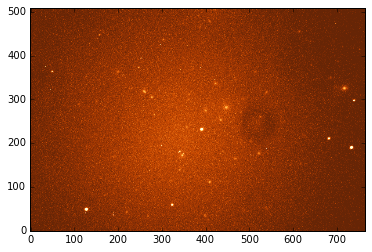

In [18]:
plt.imshow(sci_im_darksub, vmin=(439.67860 - 40.49545),
           vmax=(439.67860 + 10*40.49545), origin='lower',cmap='YlOrBr_r')

Theres a very non-uniform background that seems to peak near the center and die off closer to the edges. there is also a doughnut thingy near the center of the frame. Lets see if we can remove this by flattening the image.

### 2b) flatten the image

Lets remember how we created a master flat image from last time

In [19]:
def flat_combine(flats):
    '''
    make a combined flat field image. each flat images is normalized by its mean. 
    then the normalized flats are averaged
    
    input:
        flats: a python list to the paths of the flats you wish to combine
    output:
        avg_flat: the average of the median-normalized flats
    '''
    parent_flat=[]

    for i in xrange(0,len(flats)):
        hdulist=fits.open(flats[i])
        parent_flat.append(hdulist[0].data)
        hdulist.close()


    #convert this to a numpy array
    parent_flatAr=np.array(parent_flat)
    #now we can quickly calculate the medians
    medians=np.median(parent_flatAr, axis=(1,2))
    
    #normalize each flat by its median
    normalized_flats=[]
    for i in xrange(0,len(flats)):
        normalized_flats.append(parent_flatAr[i]/medians[i])
    
    #make it an array and quickly calculate the mean flat
    avg_flat=np.array(normalized_flats).mean(axis=0)
    return avg_flat

Now that we have everything in place, lets calculate the average flat, and flatten our dark-subtracted image

In [20]:
flats=glob.glob('/Users/ih64/Desktop/ast266_data_analysis/HW4/Flat*')
avg_flat=flat_combine(flats)

sci_dark_flat= sci_im_darksub / avg_flat

In [21]:
sigmaClip(sci_dark_flat, 3)

after 11 recursive calls, we have no more elements outside threshold
the mean and std of the final clipped array are 438.31398 and 23.74130 respectively


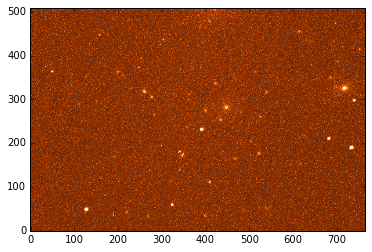

In [22]:
plt.imshow(sci_dark_flat, vmin=(438.31398-23.74130),
           vmax=(438.31398 + 10*23.74130), origin='lower',cmap='YlOrBr_r')

The background looks a lot better now, and the dougnut thingy is gone :)